In [2]:
#!pip install packaging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from packaging import version
import time

assert(version.parse(tf.__version__) >= version.parse("2.0.0-aplha"))

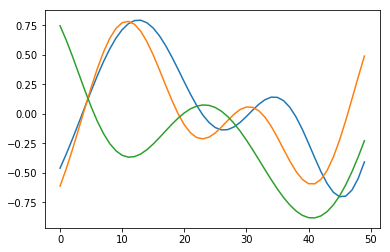

In [3]:
def generate_serie(size, step) :
    maxT = size*step
    t = np.arange(0, maxT, step)
#    return (np.sin(t+np.cos(t*0.31))).astype(np.float32)
    return (np.sin(t+np.sin(t*.31)) * np.sin(t / 3.3485)).astype(np.float32)
#    return (np.sin(t+np.cos(t)) + .34158*np.sin(t * 3.3485)).astype(np.float32)
#return (t * np.sin(t)/maxT + .3*np.sin(t * 3.3)).astype(np.float32)

def split(arr, *count) :
    total = sum(count)
    p0 = 0
    for i in count :
        p1 = p0 + i
        yield arr[int(len(arr)*p0/total):int(len(arr)*p1/total)]
        p0 = p1
    
    
np.random.seed(42)

N_STEPS = n_steps = 50
data = generate_serie(14001, .18)
data = [(data[i:i+n_steps], data[i+1:i+n_steps+1]) for i in range(len(data)-n_steps-1)] 
np.random.shuffle(data)

#plt.plot(data[1][0])
#plt.plot(data[2][0])
#plt.plot(data[3][0])
#plt.show()

spt_data = np.reshape([data[i][0] for i in range(len(data))], (-1, n_steps, 1))
spt_lbl = np.reshape([data[i][1] for i in range(len(data))], (-1, n_steps, 1))

train_size = 80
valid_size = 15
test_size = 5

[train, valid, test] = zip(split(spt_data, train_size, valid_size, test_size), 
                           split(spt_lbl, train_size, valid_size, test_size))

plt.plot(train[0][1])
plt.plot(train[0][2])
plt.plot(train[0][3])
plt.show()

train = tf.data.Dataset.from_tensor_slices((train[0], train[1]))
valid = tf.data.Dataset.from_tensor_slices((valid[0], valid[1]))
test = tf.data.Dataset.from_tensor_slices((test[0], test[1]))
#train = train.batch(64, True)
#valid = valid.batch(64, True)
#test = test.batch(64, True)


In [ ]:
if False :
    #BATCH_SIZE = 64
    BATCH_SIZE = 8
    dataset = tf.data.Dataset.from_tensor_slices((spt_data, spt_lbl))
    #dataset = tf.data.Dataset.from_tensor_slices(spt_data)
    #dataset = dataset.batch(BATCH_SIZE, True)
    #print(dataset.take(64))
    #for i,(a,b) in enumerate(dataset) : print("------", i, a, b)


In [6]:
class Encoder(tf.keras.Model):
  def __init__(self, hidden1, enc_units, batch_sz) : #, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.hidden1 = hidden1
    self.enc_units = enc_units
    self.batch_sz = batch_sz
    #self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    #self.inputi = tf.keras.Input(shape=(1,))
    #self.input_shape = tf.TensorShape([None,1])
    self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                    return_sequences=True,
                                    #return_state=True,
                         #           stateful=True,
                                    #activation="selu",
                                    #activation="linear",
                                    #recurrent_activation="selu",  
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(self.enc_units,
                                    activation="linear")

    #self.gru = tf.keras.layers.RNN(
    #    tf.keras.layers.GRUCell(self.enc_units,
    #                               recurrent_initializer='glorot_uniform'),
    #   return_sequences=True,
    #   return_state=True
    #)
    
#  def call(self, x, initial_state=None): #, hidden):
  def call(self, x) : #, initial_state=None): #, hidden):
    #print(x, initial_state)
    #x2 = self.inputi(x)
    #print(x2)
#    if (initial_state!=None) :
#        self.lstm.reset_states(initial_state)
    
    #output = self.lstm(x) #, initial_state = hidden)
    x = self.lstm(x) #, initial_state = hidden)
    output = self.dense(x)
    #output, self.state = self.lstm(x, self.state) #, initial_state = hidden)
    return output #, state

  #def reset_states(self) :
  #  self.lstm.reset_states()

#  def reset_states(self, initial_state=None) :
#    #print(self.lstm.input_spec)
#    self.lstm.reset_states(initial_state)

#  def initialize_hidden_state(self):
#    return tf.zeros((self.batch_sz, self.enc_units))
 

In [ ]:
if False :
    optimizer = tf.keras.optimizers.Adam()
    loss_object = tf.keras.losses.MeanSquaredError()
    mask = np.concatenate((
        np.zeros((19,1), dtype=np.float32), 
        np.ones((1,1), dtype=np.float32)))
    #print(mask)

    def loss_function(real, pred):
        #print("loss_function")
        #mask = tf.math.logical_not(tf.math.equal(real, 0))
        #print(real, pred)
        real *= mask
        pred *= mask
        #print(real, pred)
        loss_ = loss_object(real, pred)
        #print(loss_)

        #mask = tf.cast(mask, dtype=loss_.dtype)
        #loss_ *= mask
        #print(loss_)

        return tf.reduce_mean(loss_)


In [ ]:
if False :
    #@tf.function
    def train_step(model, inputs, targets):
        with tf.GradientTape() as tape:
            # Make a prediction on all the batch
            predictions = model(inputs)
            # Get the error/loss on these predictions
            loss = loss_function(targets, predictions)
        # Compute the gradient which respect to the loss
        gradients = tape.gradient(loss, model.trainable_variables)
        # Change the weights of the model
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # The metrics are accumulate over time. You don't need to average it yourself.
        #train_loss(loss)
        #train_accuracy(targets, predictions)
        return loss

In [7]:
BATCH_SIZE = 64*8
EPOCHS = 4

#encoder = keras.models.Sequential([
#    keras.layers.LSTM(20, return_sequences=True),
#    keras.layers.LSTM(20, return_sequences=True),
#    keras.layers.TimeDistributed(keras.layers.Dense(1))
#])

encoder = Encoder(10, N_STEPS, BATCH_SIZE)
encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
encoder.summary()
encoder.compile(optimizer="Adam", loss="MSE")
#encoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
#print(len(train[0]))
#print(len(train[0])//BATCH_SIZE)
#print(len(train[0])//BATCH_SIZE*BATCH_SIZE)
#print(len(valid[0]))
#print(len(valid[0])//BATCH_SIZE)
#print(len(valid[0])//BATCH_SIZE*BATCH_SIZE)
#tbs = len(train[0])//BATCH_SIZE*BATCH_SIZE
#vbs = len(valid[0])//BATCH_SIZE*BATCH_SIZE

#a = encoder(train[0][:8])
#print(a)
#history = encoder.fit(train, epochs=EPOCHS) #, batch_size=BATCH_SIZE, shuffle=False)
#history = encoder.fit(train[0][:tbs], train[1][:tbs], epochs=EPOCHS, batch_size=BATCH_SIZE)
history = encoder.fit(train.batch(64, True), epochs=EPOCHS, validation_data=valid.batch(64, True), shuffle=False) # , batch_size=BATCH_SIZE
#history = encoder.fit(train[0][:tbs], train[1][:tbs], epochs=EPOCHS, validation_data=(valid[0][:vbs], valid[1][:vbs]), batch_size=BATCH_SIZE)
#a = encoder(train[0][:8])
#print(a)


Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_1 (UnifiedLSTM) multiple                  10400     
_________________________________________________________________
dense_1 (Dense)              multiple                  2550      
Total params: 12,950
Trainable params: 12,950
Non-trainable params: 0
_________________________________________________________________
Epoch 1/4
174/174 [==============================] - 8s 44ms/step - loss: 0.0718 - val_loss: 0.0101
Epoch 2/4
174/174 [==============================] - 6s 37ms/step - loss: 0.0072 - val_loss: 0.0052
Epoch 3/4
174/174 [==============================] - 6s 37ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 4/4
174/174 [==============================] - 6s 33ms/step - loss: 0.0029 - val_loss: 0.0024


dict_keys(['loss', 'val_loss'])


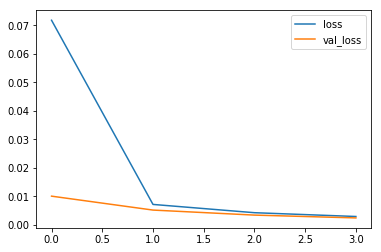

In [8]:
#print(history)
#print(history.history)
print(history.history.keys())

plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [ ]:
if False :
    EPOCHS = 400

    encoder = Encoder(10, 50, BATCH_SIZE)
    encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
    encoder.summary()

    #print(dataset)
    #print(len(list(dataset)))
    steps_per_epoch = len(list(dataset)) #//BATCH_SIZE
    #print(steps_per_epoch)

    for epoch in range(EPOCHS):
      start = time.time()

      enc_hidden = encoder.initialize_hidden_state()
      encoder.reset_states()
      total_loss = 0

      #print(dataset)
      for (batch, (inp, targ)) in enumerate(dataset):
        #if (batch!=0) : continue
        #print(len(inp), len(targ))
        batch_loss = train_step(encoder, inp, targ)
        #print(batch_loss)
        total_loss += batch_loss

        if batch % 10 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

      print('Epoch {} Loss {:.4f}'.format(epoch + 1, 
                                          total_loss / steps_per_epoch))
    #    break
      print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    #  break
      # saving (checkpoint) the model every 2 epochs
    #  if (epoch + 1) % 2 == 0:
    #    checkpoint.save(file_prefix = checkpoint_prefix)
    #


In [ ]:
if False :
    tm = np.ones((20,1), dtype=np.float32) - mask
    d = list(dataset)[0]
    #print(d[0])
    t = encoder(d[0])
    #print(t)
    #print("-------")
    print(t- d[1])


In [ ]:
if False :
    #BATCH_SIZE = 64
    #f = dataset.take(1)
    #print(f.shape)
    f = next(iter(dataset))
    #print(f)
    print("f : ", f.shape)
    #print("f : ", f.shape, f)
    #f = tf.zeros((BATCH_SIZE, 2, 10))
    #f = tf.ones((BATCH_SIZE, 1, 1))

    #print(list(f))
    #print("f : ", f.shape, f)
    #print("f2 : ", f2.shape, f2)
    encoder = Encoder(1, 3) # BATCH_SIZE)
    #print(encoder.lstm.input_spec[0])
    #encoder.reset_states(encoder.initialize_hidden_state());
    encoder.build(tf.TensorShape([3,None,1]))

    """ 
        shape = (A, B, C)
        A : BATCH_SIZE (nombre de lot envoyer en meme temps)
        B : Nombre de dépliage
        C : Nombre d'input 

    """


    #encoder.build(tf.TensorShape([1,None,1]))
    #encoder.build([tf.TensorShape([5,1,1]), tf.TensorShape([5,1])])
    encoder.summary()
    print(encoder.lstm.states)
    #encoder.reset_states()
    f = tf.constant([[[1.]],[[0.2]],[[0.5]]], dtype=tf.float32)
    sample_output = encoder(f) #, sample_hidden)
    print("---------------")
    print(sample_output)
    print("---------------")
    print(encoder.lstm.states[1])

    """encoder.lstm.reset_states()
    sample_output = encoder(f) #, sample_hidden)
    print("---------------")
    print(sample_output)
    print("---------------")
    print(encoder.lstm.states[1])"""

    encoder.summary()

    #sample_hidden = encoder.initialize_hidden_state()
    #sample_hidden = tf.zeros((BATCH_SIZE,1))
    #print(sample_hidden)
    #sample_output, sample_hidden = encoder(f) #, sample_hidden)
    #sample_output = encoder(f) #, sample_hidden)
    #encoder.summary()

    #print(encoder.gru.dynamic)
    #print("---------------")
    #sample_output, sample_hidden = encoder(f2, sample_hidden)
    #print("---------------")
    #print(sample_output)
    #print(sample_output, sample_hidden)
